# Calculating Zero Beta Portfolio #

### Yearly (252 days) Rebalancing ###

In [61]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from scipy.optimize import minimize

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [62]:
# Get the important data for the Risk Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500

sp500 = pd.read_csv(rf"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

In [63]:
# Call the betas

betas_df = pd.read_csv(r"..\additional_data\betas.csv")
betas_df = betas_df.set_index('Date')
betas_df.index = pd.to_datetime(betas_df.index)

betas_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-08,1.169801,1.147189,1.020613,1.204812,0.999815,1.243746,0.981288,1.049395,1.009929,0.559332,...,0.856893,0.937214,1.708455,0.531819,1.064428,1.007787,1.002596,0.821984,1.494902,1.020760
2016-01-11,1.167770,1.135761,1.032587,1.210169,1.001209,1.238406,0.974001,1.047316,1.012501,0.559818,...,0.856111,0.937283,1.721904,0.537210,1.071017,1.007377,1.003930,0.818455,1.485398,1.023555
2016-01-12,1.166375,1.136806,1.024002,1.211396,1.003453,1.241084,0.972430,1.048343,1.015570,0.559591,...,0.854448,0.937870,1.718190,0.537422,1.070249,1.007402,0.999302,0.813795,1.482889,1.019380
2016-01-13,1.162057,1.134450,1.032051,1.216526,0.999187,1.242375,0.980352,1.049293,1.004531,0.557271,...,0.857982,0.923881,1.705672,0.532184,1.077893,1.009344,1.007880,0.828707,1.487805,1.020597
2016-01-14,1.172151,1.130829,1.095173,1.213185,0.987322,1.241761,0.976254,1.050547,1.079909,0.543485,...,0.830912,0.902395,1.727706,0.520218,1.025449,1.009536,0.980446,0.820496,1.519260,1.043191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.876024,1.037784,0.194116,0.161045,1.152206,1.811336,0.440483,0.369979,1.321823,0.050615,...,0.659139,0.629752,0.945839,0.030220,0.178951,1.048215,0.402963,0.558583,1.298215,0.644560
2024-10-23,0.885034,1.040036,0.185126,0.162425,1.155704,1.812294,0.440543,0.368008,1.320912,0.048642,...,0.657083,0.631516,0.950898,0.028141,0.178514,1.057987,0.403819,0.558005,1.297213,0.643499
2024-10-24,0.882041,1.054079,0.192155,0.158307,1.156394,1.783464,0.423049,0.364567,1.315633,0.022642,...,0.645426,0.618673,0.963019,0.010037,0.175143,1.046621,0.393233,0.547803,1.299909,0.640561


In [64]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {} 

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df['Adjusted_close']

        df = df.rename("adj_close")
        
        # Fill nans
        df = df.interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [65]:
# Create the Returns DataFrame
returns_dict = {}

# Create the Loop to Obtain the Betas
for ticker in dataframes.keys():
    df = dataframes[ticker].pct_change(1).dropna()
    returns_dict[ticker] = df

# Create the DataFrame
df_returns = pd.DataFrame.from_dict(returns_dict)
df_returns = df_returns.apply(lambda x: x.fillna(x.mean()), axis=0)

df_returns

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018738,-0.028172,-0.018819,0.000223,-0.004976,-0.018275,-0.034602,-0.000720,-0.014614,-0.010002,...,-0.013804,0.000000,-0.017020,-0.011351,-0.027362,-0.062237,-0.020318,0.037303,-0.014077,-0.006003
2015-01-06,-0.015578,0.000094,-0.004950,-0.011356,-0.020144,-0.023384,-0.019713,-0.008350,-0.019775,-0.011641,...,-0.017107,-0.001108,-0.021331,0.005321,-0.005316,-0.005881,-0.012274,-0.008477,-0.007205,-0.009756
2015-01-07,0.013272,0.014022,0.040417,0.008108,0.008223,0.010516,0.015031,0.008784,-0.002087,0.007778,...,0.016218,0.003050,0.029368,0.008635,0.010133,0.007887,0.033138,0.024870,0.025465,0.020643
2015-01-08,0.029975,0.038422,0.010459,0.020554,0.025383,0.017655,-0.014609,0.022940,0.024747,0.003528,...,0.019657,0.010779,0.012031,0.011599,0.016645,0.007546,0.017420,0.010617,0.021359,0.015399
2015-01-09,-0.007337,0.001072,-0.027355,-0.010508,-0.014743,-0.000730,-0.008530,-0.007162,-0.009014,-0.011206,...,-0.011453,-0.001367,0.012499,-0.012285,-0.001410,-0.018863,-0.001767,-0.014424,0.014613,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024130,-0.002622,0.011901,-0.007437,-0.009242,-0.004653,-0.007839,0.001478,-0.004486,-0.005327,...,-0.002959,-0.019820,0.010471,0.003941,0.005163,-0.008678,-0.004776,-0.008935,-0.001584,0.000317
2024-10-23,-0.003222,-0.021623,-0.004662,0.007664,-0.016386,0.009928,0.007003,-0.004462,-0.007574,0.016408,...,0.000140,0.006319,-0.017304,0.010050,-0.003563,0.002664,0.004949,0.004220,-0.010511,-0.002744
2024-10-24,-0.017590,-0.000823,0.009421,-0.004017,-0.004453,0.012475,0.007489,-0.002103,-0.001834,-0.002130,...,0.154343,0.008791,0.002252,0.012282,-0.005654,-0.008123,-0.006417,-0.006686,-0.016409,-0.039632


In [66]:
# Common Index

common_index = df_returns.index.intersection(betas_df.index)  # Common Date
df_returns_reindex = df_returns.reindex(common_index)
df_betas_reindex = betas_df.reindex(common_index)

In [67]:
# Calculate the Correlations Matrix
corr_matrix = df_returns_reindex.corr().values  

# Obtain Eigenvalues
eigenvalues, _ = np.linalg.eigh(corr_matrix)

# Identify how much Eigenvalues are small (high colineality)
threshold = 1e-4  # Adjust
num_redundant = sum(eigenvalues < threshold)

print(f"Number of highly colineal variables: {num_redundant}")

Number of highly colineal variables: 0


In [68]:
# Let us Calculate the Weights
def rolling_weights(
    returns, 
    betas, 
    window=252, 
    rebalance_freq=252
):

    # Lists to Store Things
    weights_list = []
    dates = []

    for i in range(window, len(returns), rebalance_freq):
        past_returns = returns.iloc[i-window:i]  # Rolling Window
        past_betas = betas.iloc[i-window:i]
        
        # Mean and Covariance
        beta = past_betas.mean()
        Sigma = past_returns.cov()

        # Inverse
        lambda_ = 1e-6  # Tikhonov Regularization
        Sigma_inv = np.linalg.inv(Sigma + lambda_ * np.eye(Sigma.shape[0]))
        
        # Sigma_inv = np.linalg.inv(Sigma)

        # Ones
        iota = np.ones(len(beta))

        # And now obtain the coefficients
        C = np.dot(np.dot(iota.T, Sigma_inv), iota)
        D = np.dot(np.dot(beta.T, Sigma_inv), beta)
        E = np.dot(np.dot(beta.T, Sigma_inv), iota)
        Delta = (D*C - E*E)
        
        w = ((D/Delta)*(Sigma_inv @ iota)) - ((E/Delta)*(Sigma_inv @ beta))

        # Save weights and dates
        weights_list.append(w)
        dates.append(returns.index[i])

    # Create the DataFrame
    weights_df = pd.DataFrame(weights_list, index=dates, columns=returns.columns)

    # Expand the DataFrame
    weights_df = weights_df.reindex(returns.index, method='ffill')

    return weights_df.dropna()

In [69]:
# Obtain the Weights

zbp_weights = rolling_weights(df_returns, betas_df)

zbp_weights

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.034696,0.020754,0.017402,-0.075848,-0.010633,0.030782,-0.013364,0.008191,-0.009715,-0.041711,...,0.007231,-0.008874,-0.000341,0.021390,-0.006233,0.000451,-0.014814,0.041109,-0.003598,0.000453
2016-01-06,-0.034696,0.020754,0.017402,-0.075848,-0.010633,0.030782,-0.013364,0.008191,-0.009715,-0.041711,...,0.007231,-0.008874,-0.000341,0.021390,-0.006233,0.000451,-0.014814,0.041109,-0.003598,0.000453
2016-01-07,-0.034696,0.020754,0.017402,-0.075848,-0.010633,0.030782,-0.013364,0.008191,-0.009715,-0.041711,...,0.007231,-0.008874,-0.000341,0.021390,-0.006233,0.000451,-0.014814,0.041109,-0.003598,0.000453
2016-01-08,-0.034696,0.020754,0.017402,-0.075848,-0.010633,0.030782,-0.013364,0.008191,-0.009715,-0.041711,...,0.007231,-0.008874,-0.000341,0.021390,-0.006233,0.000451,-0.014814,0.041109,-0.003598,0.000453
2016-01-11,-0.034696,0.020754,0.017402,-0.075848,-0.010633,0.030782,-0.013364,0.008191,-0.009715,-0.041711,...,0.007231,-0.008874,-0.000341,0.021390,-0.006233,0.000451,-0.014814,0.041109,-0.003598,0.000453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.035521,0.076701,-0.028852,0.026371,-0.045251,-0.005843,0.046286,0.051770,-0.005879,-0.096224,...,0.023316,0.026423,-0.006274,0.061529,0.000703,-0.066364,-0.016426,0.059684,-0.031012,-0.052820
2024-10-23,-0.035521,0.076701,-0.028852,0.026371,-0.045251,-0.005843,0.046286,0.051770,-0.005879,-0.096224,...,0.023316,0.026423,-0.006274,0.061529,0.000703,-0.066364,-0.016426,0.059684,-0.031012,-0.052820
2024-10-24,-0.035521,0.076701,-0.028852,0.026371,-0.045251,-0.005843,0.046286,0.051770,-0.005879,-0.096224,...,0.023316,0.026423,-0.006274,0.061529,0.000703,-0.066364,-0.016426,0.059684,-0.031012,-0.052820


In [70]:
# Calculate the ZBP

zbp_returns = ((df_returns * zbp_weights).dropna()).sum(axis = 1)
zbp_returns.name = 'ZBP'

zbp_returns

Date
2016-01-05    0.002595
2016-01-06    0.008980
2016-01-07    0.009439
2016-01-08    0.014844
2016-01-11    0.007883
                ...   
2024-10-22    0.003792
2024-10-23    0.015539
2024-10-24    0.004364
2024-10-25   -0.008058
2024-10-28    0.001691
Name: ZBP, Length: 2219, dtype: float64

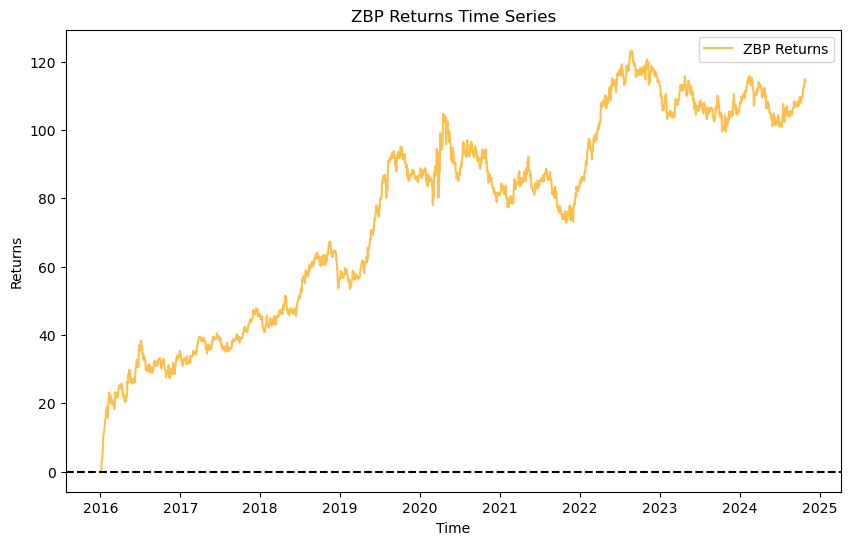

In [71]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(zbp_returns.mul(100).cumsum(), label='ZBP Returns', color='orange', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('ZBP Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

In [72]:
# Calculate the beta
risk_free_daily = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)

df_regression = pd.DataFrame()
df_regression['y'] = zbp_returns - risk_free_daily
df_regression['x'] = sp500['sp_500'].pct_change(1) - risk_free_daily
df_regression.dropna(inplace = True)
df_regression = df_regression.mul(100)

df_regression

,y,x
Date,,
2016-01-05,0.253349,0.195042
2016-01-06,0.891964,-1.317530
2016-01-07,0.937923,-2.375981
2016-01-08,1.478554,-1.089692
2016-01-11,0.782335,0.079364
...,...,...
2024-10-22,0.367821,-0.058914
2024-10-23,1.542328,-0.930668
2024-10-24,0.424982,0.203122


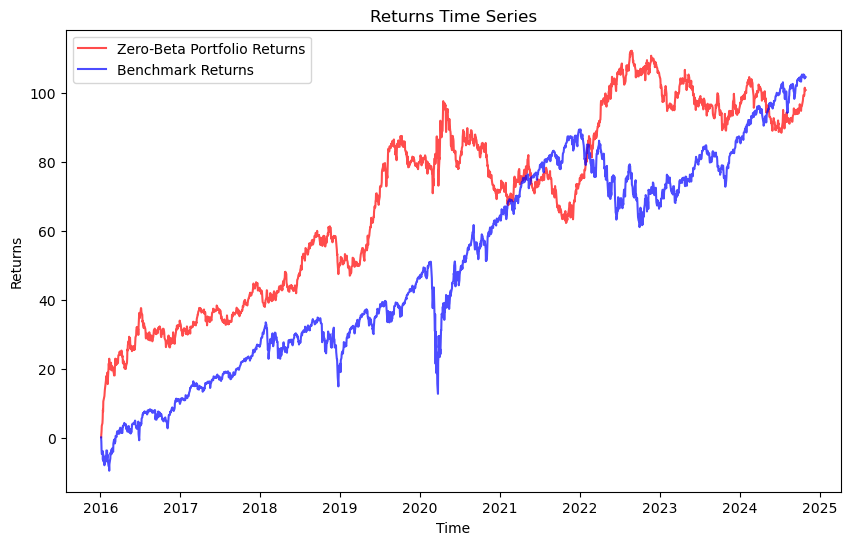

In [73]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(df_regression['y'].cumsum(), label='Zero-Beta Portfolio Returns', color='red', alpha=0.7)
plt.plot(df_regression['x'].cumsum(), label='Benchmark Returns', color='blue', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

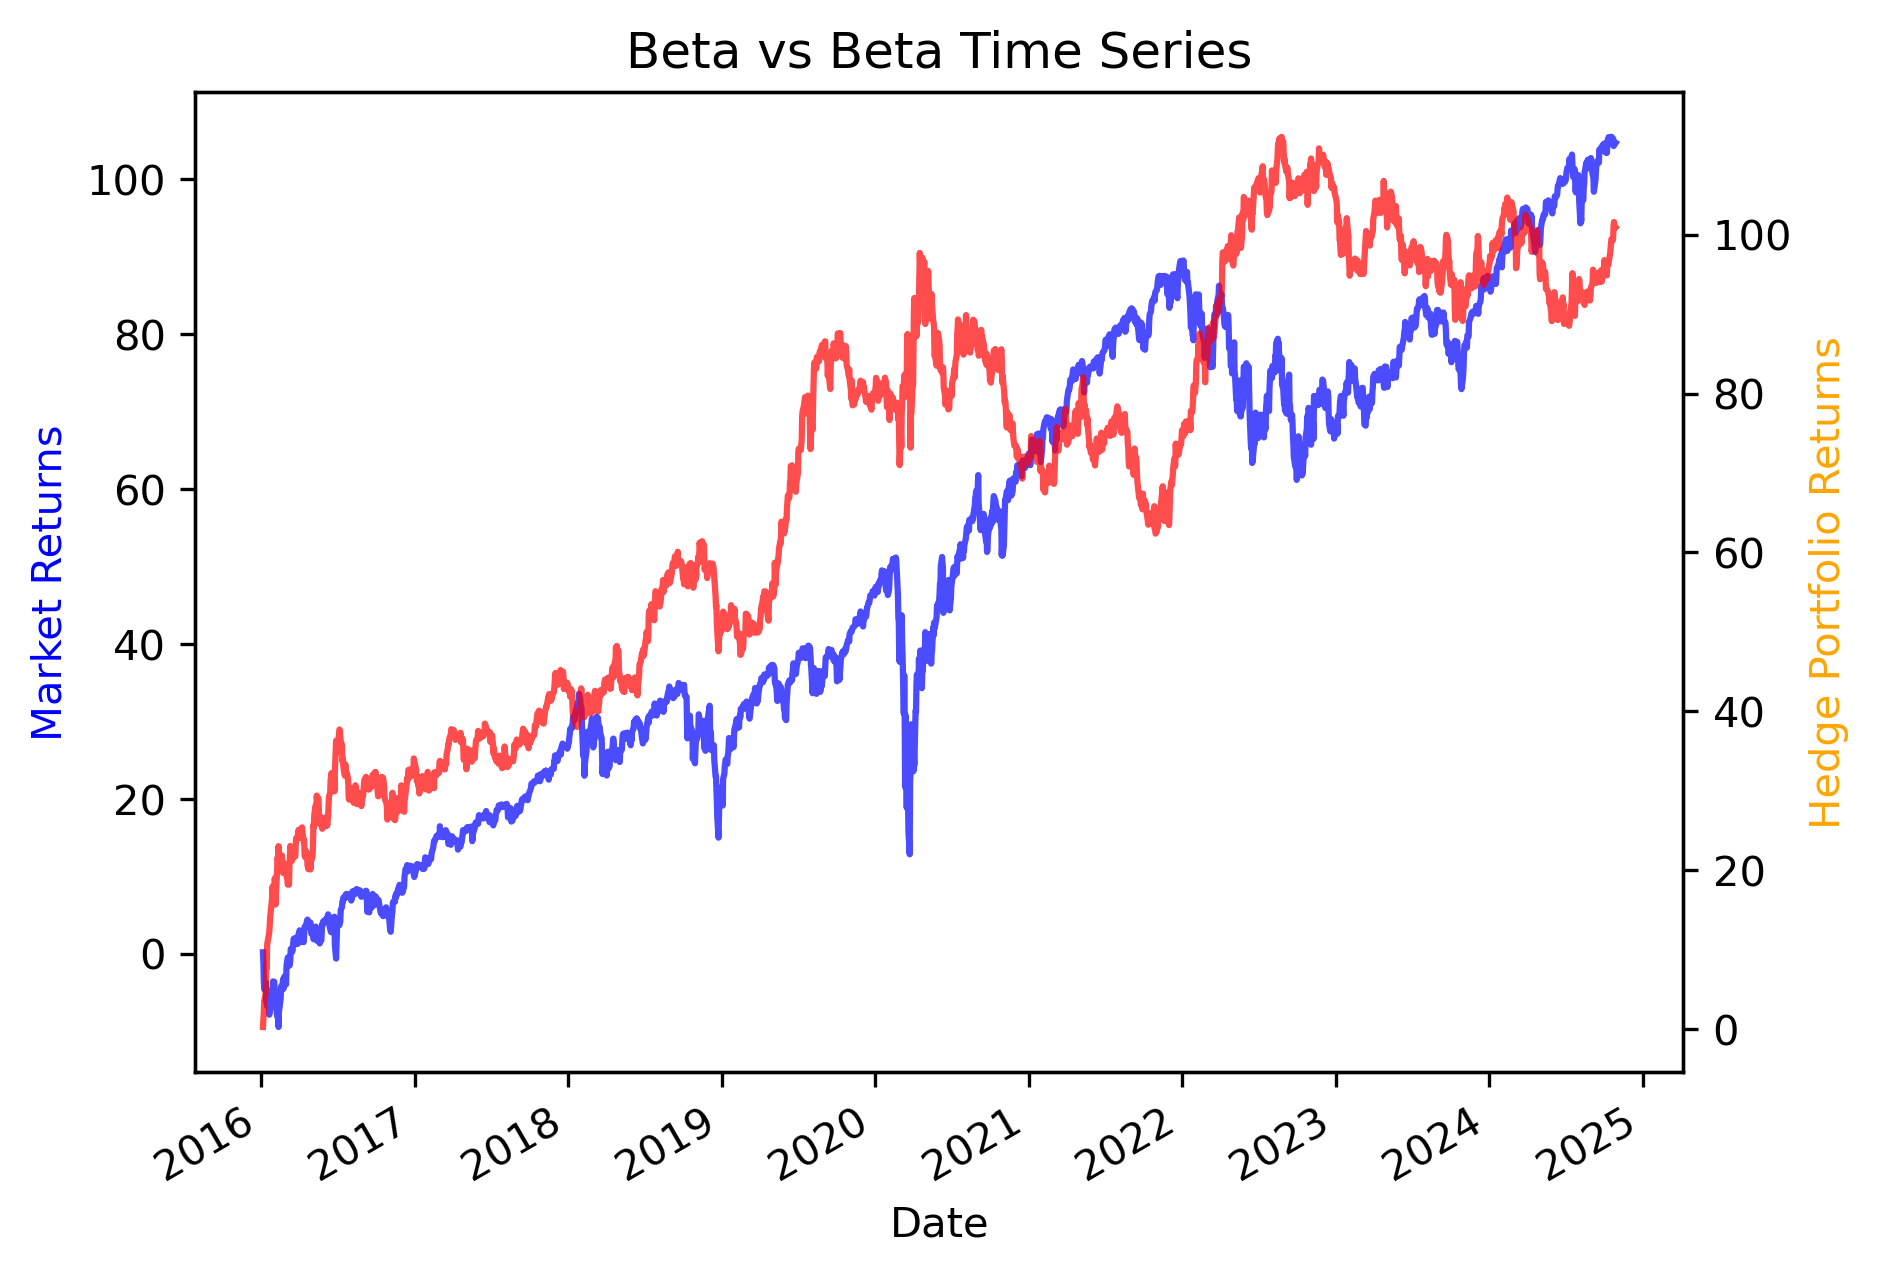

In [74]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Market Returns Plot
df_regression['x'].cumsum().plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Returns', 
    color='blue'
    )

# ZBP Returns Plot
ax2 = ax1.twinx()

df_regression['y'].cumsum().plot(color = 'red', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Returns', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

In [75]:
# Correlation between market and our hedge portfolio

df_regression.corr()

,y,x
y,1.000000,-0.017124
x,-0.017124,1.000000


In [76]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [77]:
#Model specification
window = len(df_regression)
weights = window * wexp(window, window/2)

model = sm.WLS(
    df_regression['y'], 
    sm.add_constant(df_regression['x']),
    missing='drop',
    weights=weights
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary()) 

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 1.478e-05
Date:                Tue, 08 Apr 2025   Prob (F-statistic):              0.997
Time:                        16:07:14   Log-Likelihood:                -3414.9
No. Observations:                2204   AIC:                             6834.
Df Residuals:                    2202   BIC:                             6845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0353      0.023      1.510      0.1

In [78]:
# Set rolling window size
window = 252
weights = window * wexp(window, window/2)

y = df_regression['y']
x = sm.add_constant(df_regression['x'])

# Lists to store rolling coefficients
params = []
index = []
lower_bounds = []
upper_bounds = []

# Rolling regression
for i in range(window, len(df_regression)):
    Y_window = y.iloc[i - window:i]
    X_window = x.iloc[i - window:i]

    # Fit WLS model
    model = sm.WLS(Y_window, X_window, missing='drop', weights=weights).fit()

    # Store coefficients (const, X1, X2)
    params.append(model.params.values)
    index.append(df_regression.index[i])  # Use the last date of the window

    # Store lower and upper bounds of 95% confidence intervals
    ci = model.conf_int(alpha=0.05)  # 95% CI
    lower_bounds.append(ci.iloc[:, 0].values)  # First column: lower bound
    upper_bounds.append(ci.iloc[:, 1].values)  # Second column: upper bound


In [79]:
# Convert list of coefficients to DataFrame
parameters_df = pd.DataFrame(params, columns=x.columns, index=index)

parameters_df

,const,x
2017-01-06,0.094074,-0.356427
2017-01-09,0.093850,-0.356431
2017-01-10,0.086237,-0.349719
2017-01-11,0.086483,-0.349578
2017-01-12,0.076825,-0.348669
...,...,...
2024-10-22,0.039429,-0.000896
2024-10-23,0.041062,-0.000406
2024-10-24,0.053687,-0.018092
2024-10-25,0.057395,-0.018055


In [80]:
# Lower bounds DataFrame
lower_df = pd.DataFrame(lower_bounds, columns=[f'{col}_lower' for col in x.columns], index=index)

lower_df

,const_lower,x_lower
2017-01-06,-0.021077,-0.512417
2017-01-09,-0.021002,-0.512329
2017-01-10,-0.028688,-0.506469
2017-01-11,-0.028185,-0.507944
2017-01-12,-0.038007,-0.507945
...,...,...
2024-10-22,-0.085256,-0.155779
2024-10-23,-0.083332,-0.155513
2024-10-24,-0.071291,-0.173945
2024-10-25,-0.067300,-0.173955


In [81]:
# Upper bounds DataFrame
upper_df = pd.DataFrame(upper_bounds, columns=[f'{col}_upper' for col in x.columns], index=index)

upper_df

,const_upper,x_upper
2017-01-06,0.209226,-0.200436
2017-01-09,0.208701,-0.200533
2017-01-10,0.201162,-0.192969
2017-01-11,0.201151,-0.191211
2017-01-12,0.191657,-0.189393
...,...,...
2024-10-22,0.164115,0.153987
2024-10-23,0.165456,0.154701
2024-10-24,0.178665,0.137762
2024-10-25,0.182090,0.137845


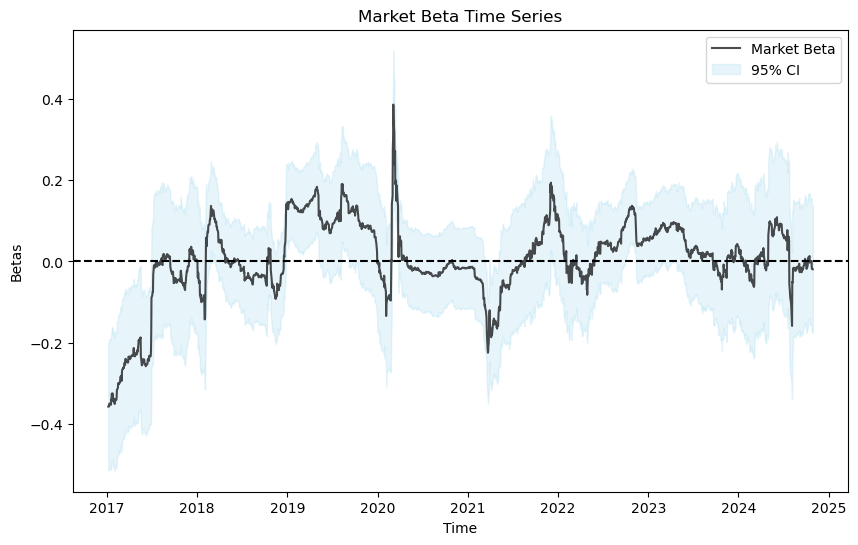

In [82]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(parameters_df['x'], label='Market Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['x_lower'], upper_df['x_upper'], color='skyblue', alpha=0.2, label='95% CI')
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Market Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

In [108]:
zbp_returns.name = 'zero_beta_portfolio'
# zbp_returns.to_csv(r"..\additional_data\zero_beta.csv", header=True)